### Install libraries and set minor cleaning function

In [ ]:
!pip install transformers datasets evaluate

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

HTML_PATTERN = re.compile('<.*?>')
nltk.download('stopwords')
STOPWORDS_LIST = set(stopwords.words('english'))

def noise_entity_removal(target_input):
    #will remove digits
    target_input = re.sub(r'\d',' ',target_input)
    
    # convert to lower case
    target_input = target_input.lower()
    
    # remove html tags
    target_input = re.sub(HTML_PATTERN, ' ', target_input)
    
    # remove non-word characters like #,*,% etc
    target_input = re.sub(r'\W',' ', target_input)
    
    #will remove extra spaces
    target_input = re.sub(r'\s+',' ',target_input)

    #remove words less than 2 characters
    target_input = re.sub(r'\b\w{1}\b', '', target_input)

    return target_input

def label_to_integer(sentiment_label):
    if sentiment_label.lower() == 'positive':
        return 1
    elif sentiment_label.lower() == 'negative':
        return 0
    else:
        return None


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# MODEL 1

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_link = "./drive/MyDrive/DSA4263/model1/checkpoint-1025"
model = AutoModelForSequenceClassification.from_pretrained(model_link)
tokenizer = AutoTokenizer.from_pretrained(model_link)

## ASSESS ON LEFT-OUT DATA

In [ ]:
full_data = pd.read_csv('./drive/MyDrive/DSA4263/reviews.csv') # link to file to be changed later
full_data['processed_text'] = full_data['Text'].apply(lambda x:noise_entity_removal(x))
full_data['Sentiment'] = full_data['Sentiment'].apply(lambda x:label_to_integer(x))
df = full_data[['Sentiment', 'processed_text']]

### PRE-PROCESS

In [ ]:
CONFIG1 = {
    'this_time': 1,
    'random_seed': 4263,
    'test_size': 0.2,
    'val_size': 0.25, # relative to the remaining training data -> (train, val, test) = (60, 20, 20),
    'retrained_model': 'distilbert-base-uncased',
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16,
    'num_train_epochs': 10,
    'weight_decay': 0.01,
    'evaluation_strategy' : "epoch",
    'save_strategy': "epoch"
}

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = CONFIG1['test_size'], random_state=CONFIG1['random_seed'], shuffle=True)
train_df, val_df = train_test_split(train_df, test_size = CONFIG1['val_size'], random_state=CONFIG1['random_seed'], shuffle=True)

import datasets

train_dataset = datasets.Dataset.from_dict({
    'text': train_df['processed_text'],
    'label': train_df['Sentiment']
})

val_dataset = datasets.Dataset.from_dict({
    'text': val_df['processed_text'],
    'label': val_df['Sentiment']
})

test_dataset = datasets.Dataset.from_dict({
    'text': test_df['processed_text'],
    'label': test_df['Sentiment']
})

full_dataset = datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'val': val_dataset
})

full_dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3266
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1089
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1089
    })
})

In [ ]:
## LOAD A DistilBERT tokenizer to preprocess the text field

BERT_PRETRAINED_MODEL = CONFIG1['retrained_model']

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(BERT_PRETRAINED_MODEL)

# Create a preprocessing function to tokenize text and truncate sequences to be
# not longer than DistilBERT

def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

tokenized_dataset = full_dataset.map(preprocess_function, batched=True)

# Dynamically pad the sentences to the longest length in a batch during collation, 
# instead of padding the whole dataset to the maximum length.

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/4409 [00:00<?, ? examples/s]

Map:   0%|          | 0/545 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

### INFERENCE

In [ ]:
# from transformers import AutoTokenizer

# text = [x for x in tokenized_dataset['test']['text'] if len(x.split(' ')) > 512][0] # edge case of more than 512 tokens
# tokenizer = AutoTokenizer.from_pretrained("./drive/MyDrive/DSA4263/model1/checkpoint-1025")
# inputs = tokenizer(text, return_tensors="pt", truncation=True)

# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained("./drive/MyDrive/DSA4263/model1/checkpoint-1025")
# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]

'Negative'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# ./model/DistilBERT
real_labels = full_dataset['test']['label']
model_link = "./drive/MyDrive/DSA4263/model1/checkpoint-1025"
model = AutoModelForSequenceClassification.from_pretrained(model_link)
tokenizer = AutoTokenizer.from_pretrained(model_link)
predicted_labels = []
with torch.no_grad():
  for text in full_dataset['test']['text']:
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    predicted_labels.append(predicted_class_id)

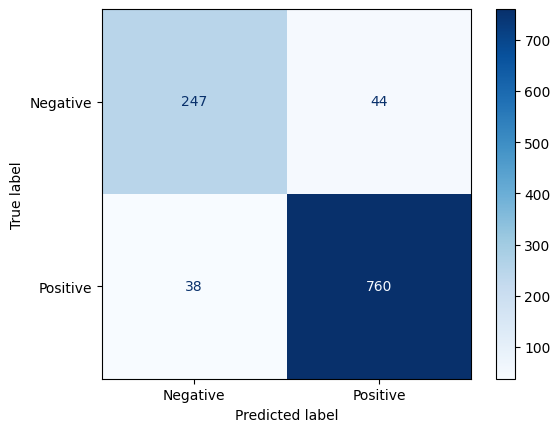

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(predicted_labels, real_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(real_labels, predicted_labels, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['0'])
print('accuracy: ', report['accuracy'])

positive:  {'precision': 0.9523809523809523, 'recall': 0.945273631840796, 'f1-score': 0.9488139825218477, 'support': 804}
negative:  {'precision': 0.8487972508591065, 'recall': 0.8666666666666667, 'f1-score': 0.8576388888888888, 'support': 285}
accuracy:  0.9247015610651974


## ASSESS ON Twitter Data

### Twitter Validation Data

In [ ]:
full_data = pd.read_csv('./drive/MyDrive/DSA4263/twitter_validation.csv', header=None) # link to file to be changed later

# full_data.head()
full_data.columns = ['sth1', 'sth2', 'Sentiment', 'Text']
full_data['processed_text'] = full_data['Text'].apply(lambda x:noise_entity_removal(x))
full_data['Sentiment'] = full_data['Sentiment'].apply(lambda x:label_to_integer(x))
df = full_data[['Sentiment', 'processed_text']]
df = df.loc[df['Sentiment'].isin([0,1])]
df.head()

,Sentiment,processed_text
2,0.0,microsoft why do pay for word when it functi...
3,0.0,csgo matchmaking is so full of closet hacking ...
5,0.0,hi eahelp ve had madeleine mccann in my cella...
6,1.0,thank you eamaddennfl new te austin hooper in ...
7,1.0,rocket league sea of thieves or rainbow six si...


In [ ]:
len(df)

543

#### PRE-PROCESS

In [ ]:
import datasets
test_dataset = datasets.Dataset.from_dict({
    'text': df['processed_text'],
    'label': df['Sentiment']
})

test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 543
})

#### INFERENCE

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

real_labels = test_dataset['label']
# model_link = "./drive/MyDrive/DSA4263/model1/checkpoint-1025"
# model = AutoModelForSequenceClassification.from_pretrained(model_link)
# tokenizer = AutoTokenizer.from_pretrained(model_link)
predicted_labels = []
with torch.no_grad():
  for text in test_dataset['text']:
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    predicted_labels.append(predicted_class_id)

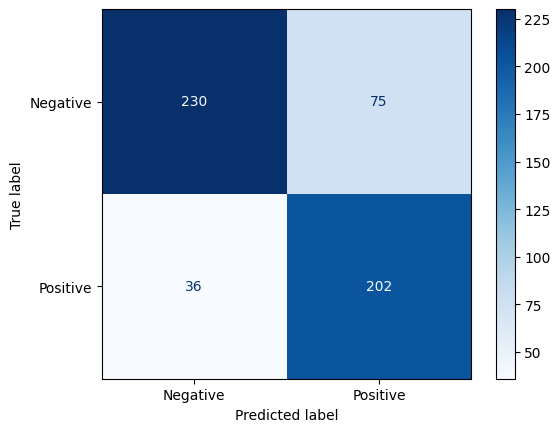

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(predicted_labels, real_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(real_labels, predicted_labels, output_dict=True)
print('positive: ', report['1.0'])
print('negative: ', report['0.0'])
print('accuracy: ', report['accuracy'])

positive:  {'precision': 0.8487394957983193, 'recall': 0.7292418772563177, 'f1-score': 0.7844660194174757, 'support': 277}
negative:  {'precision': 0.7540983606557377, 'recall': 0.8646616541353384, 'f1-score': 0.8056042031523643, 'support': 266}
accuracy:  0.7955801104972375


### Twitter Training Data

In [ ]:
full_data = pd.read_csv('./drive/MyDrive/DSA4263/twitter_training.csv', header=None) # link to file to be changed later

# full_data.head()
full_data.columns = ['sth1', 'sth2', 'Sentiment', 'Text']
full_data = full_data.loc[~full_data['Text'].isna()]
full_data['processed_text'] = full_data['Text'].apply(lambda x:noise_entity_removal(x))
full_data['Sentiment'] = full_data['Sentiment'].apply(lambda x:label_to_integer(x))
df = full_data[['Sentiment', 'processed_text']]
df = df.loc[df['Sentiment'].isin([0,1])]
df.head()

,Sentiment,processed_text
0,1.0,im getting on borderlands and will murder you...
1,1.0,am coming to the borders and will kill you all
2,1.0,im getting on borderlands and will kill you all
3,1.0,im coming on borderlands and will murder you ...
4,1.0,im getting on borderlands and will murder you...


#### PRE-PROCESS

In [ ]:
import datasets
test_dataset = datasets.Dataset.from_dict({
    'text': df['processed_text'],
    'label': df['Sentiment']
})

test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 43013
})

#### INFERENCE

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

real_labels = test_dataset['label']
# model_link = "./drive/MyDrive/DSA4263/model1/checkpoint-1025"
# model = AutoModelForSequenceClassification.from_pretrained(model_link)
# tokenizer = AutoTokenizer.from_pretrained(model_link)
predicted_labels = []
with torch.no_grad():
  for text in test_dataset['text']:
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    predicted_labels.append(predicted_class_id)

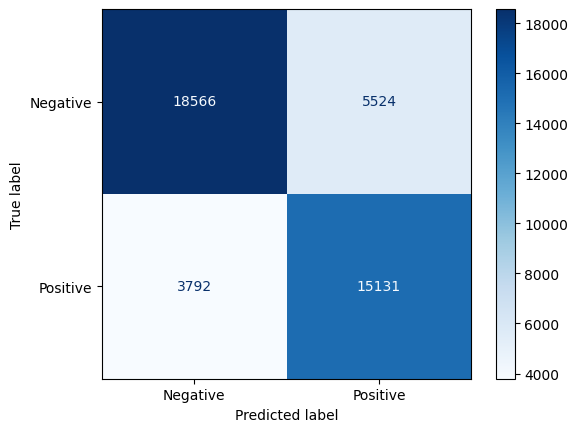

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(predicted_labels, real_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(real_labels, predicted_labels, output_dict=True)
print('positive: ', report['1.0'])
print('negative: ', report['0.0'])
print('accuracy: ', report['accuracy'])

positive:  {'precision': 0.7996089414997622, 'recall': 0.732558702493343, 'f1-score': 0.7646167062509475, 'support': 20655}
negative:  {'precision': 0.7706932337069323, 'recall': 0.8303962787369175, 'f1-score': 0.7994316224595247, 'support': 22358}
accuracy:  0.7834143166019576


In [ ]:
# url_list = []
# for i in range(0, (end_date-start_date).days+1):
#     dt_string = (start_date + i*day_delta).strftime('%Y-%m-%d')
#     url_list.append(psi_url + dt_string)

# def get_url(url):
#     return requests.get(url)

# with ThreadPoolExecutor(max_workers=500) as pool:
#     response_list = list(pool.map(get_url,url_list))